In [1]:
import tensorflow as tf
import keras
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output as cls

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
root_path = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data/'
class_names = ['Cat','Cow','Dog','Elephant', 'Gorilla']
n_classes = len(class_names)

class_dis = [len(os.listdir(root_path + name)) for name in class_names]

print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 5 
Class Names : ['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla']


In [3]:
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [4]:
valid_path = '/kaggle/input/animal-image-classification-dataset/Validation Data/Validation Data/'

class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [5]:
test_path = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data/'

class_dis = [len(os.listdir(test_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [6]:
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

train_ds = train_gen.flow_from_directory(root_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
valid_ds = valid_gen.flow_from_directory(valid_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
test_ds = test_gen.flow_from_directory(test_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names)

Found 10000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 995 images belonging to 5 classes.


In [7]:
def plot_learning_curves(history, lr):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss'+" Lr = "+lr)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy'+" Lr = "+lr)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[np.argmax(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
            
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

Epoch 1/15
313/313 [==============================] - 245s 647ms/step - loss: 1.4258 - accuracy: 0.4737 - val_loss: 13.4887 - val_accuracy: 0.1720
Epoch 2/15
313/313 [==============================] - 140s 447ms/step - loss: 1.1326 - accuracy: 0.5660 - val_loss: 1.2023 - val_accuracy: 0.5100
Epoch 3/15
313/313 [==============================] - 140s 448ms/step - loss: 0.9466 - accuracy: 0.6418 - val_loss: 1.1459 - val_accuracy: 0.5960
Epoch 4/15
313/313 [==============================] - 139s 442ms/step - loss: 0.8540 - accuracy: 0.6811 - val_loss: 0.9498 - val_accuracy: 0.6780
Epoch 5/15
313/313 [==============================] - 136s 435ms/step - loss: 0.8067 - accuracy: 0.7034 - val_loss: 1.9773 - val_accuracy: 0.6620
Epoch 6/15
313/313 [==============================] - 137s 439ms/step - loss: 0.7794 - accuracy: 0.7162 - val_loss: 2.3548 - val_accuracy: 0.4140
Epoch 7/15
313/313 [==============================] - 136s 435ms/step - loss: 0.7126 - accuracy: 0.7344 - val_loss: 1.9863 

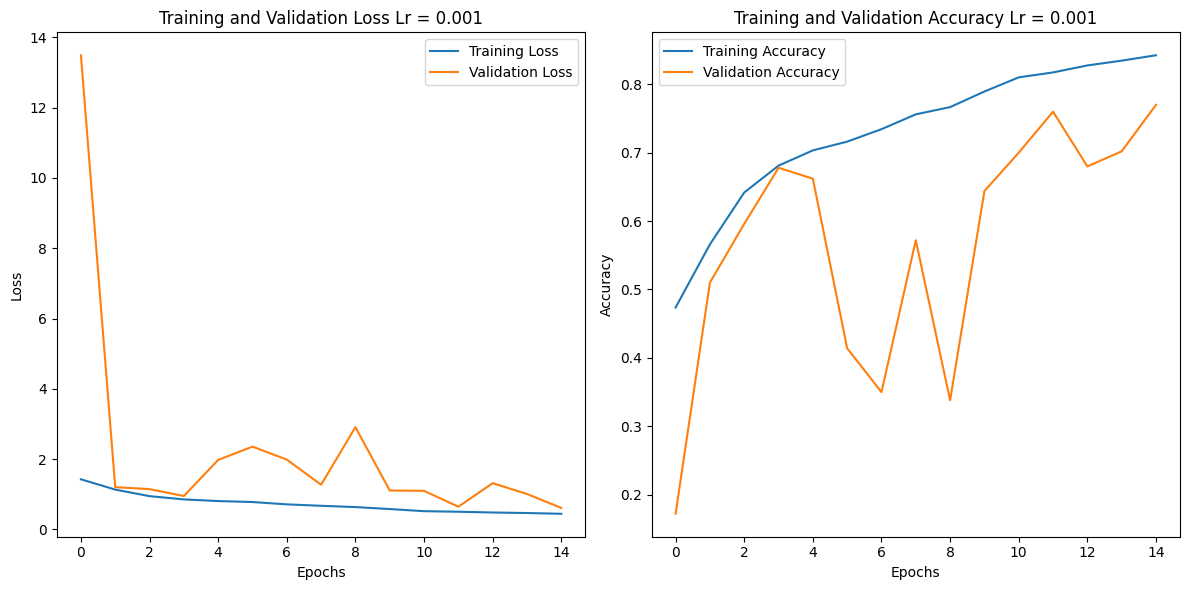

In [9]:
model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True,weights = None, classes=5, classifier_activation='softmax')
epochs = 15
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/resnet50_checkpoints/",
    monitor= 'val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq='epoch',
)

history_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    validation_data=valid_ds,
    verbose=1
)
plot_learning_curves(history_resnet50, "0.001")

In [10]:
model = history_resnet50.model

In [11]:
loss_val, accuracy = model.evaluate(test_ds)
print("Loss value = ", loss_val)
print("accuracy = ", accuracy)

32/32 [==============================] - 9s 270ms/step - loss: 0.7248 - accuracy: 0.7508
Loss value =  0.724844753742218
accuracy =  0.7507537603378296


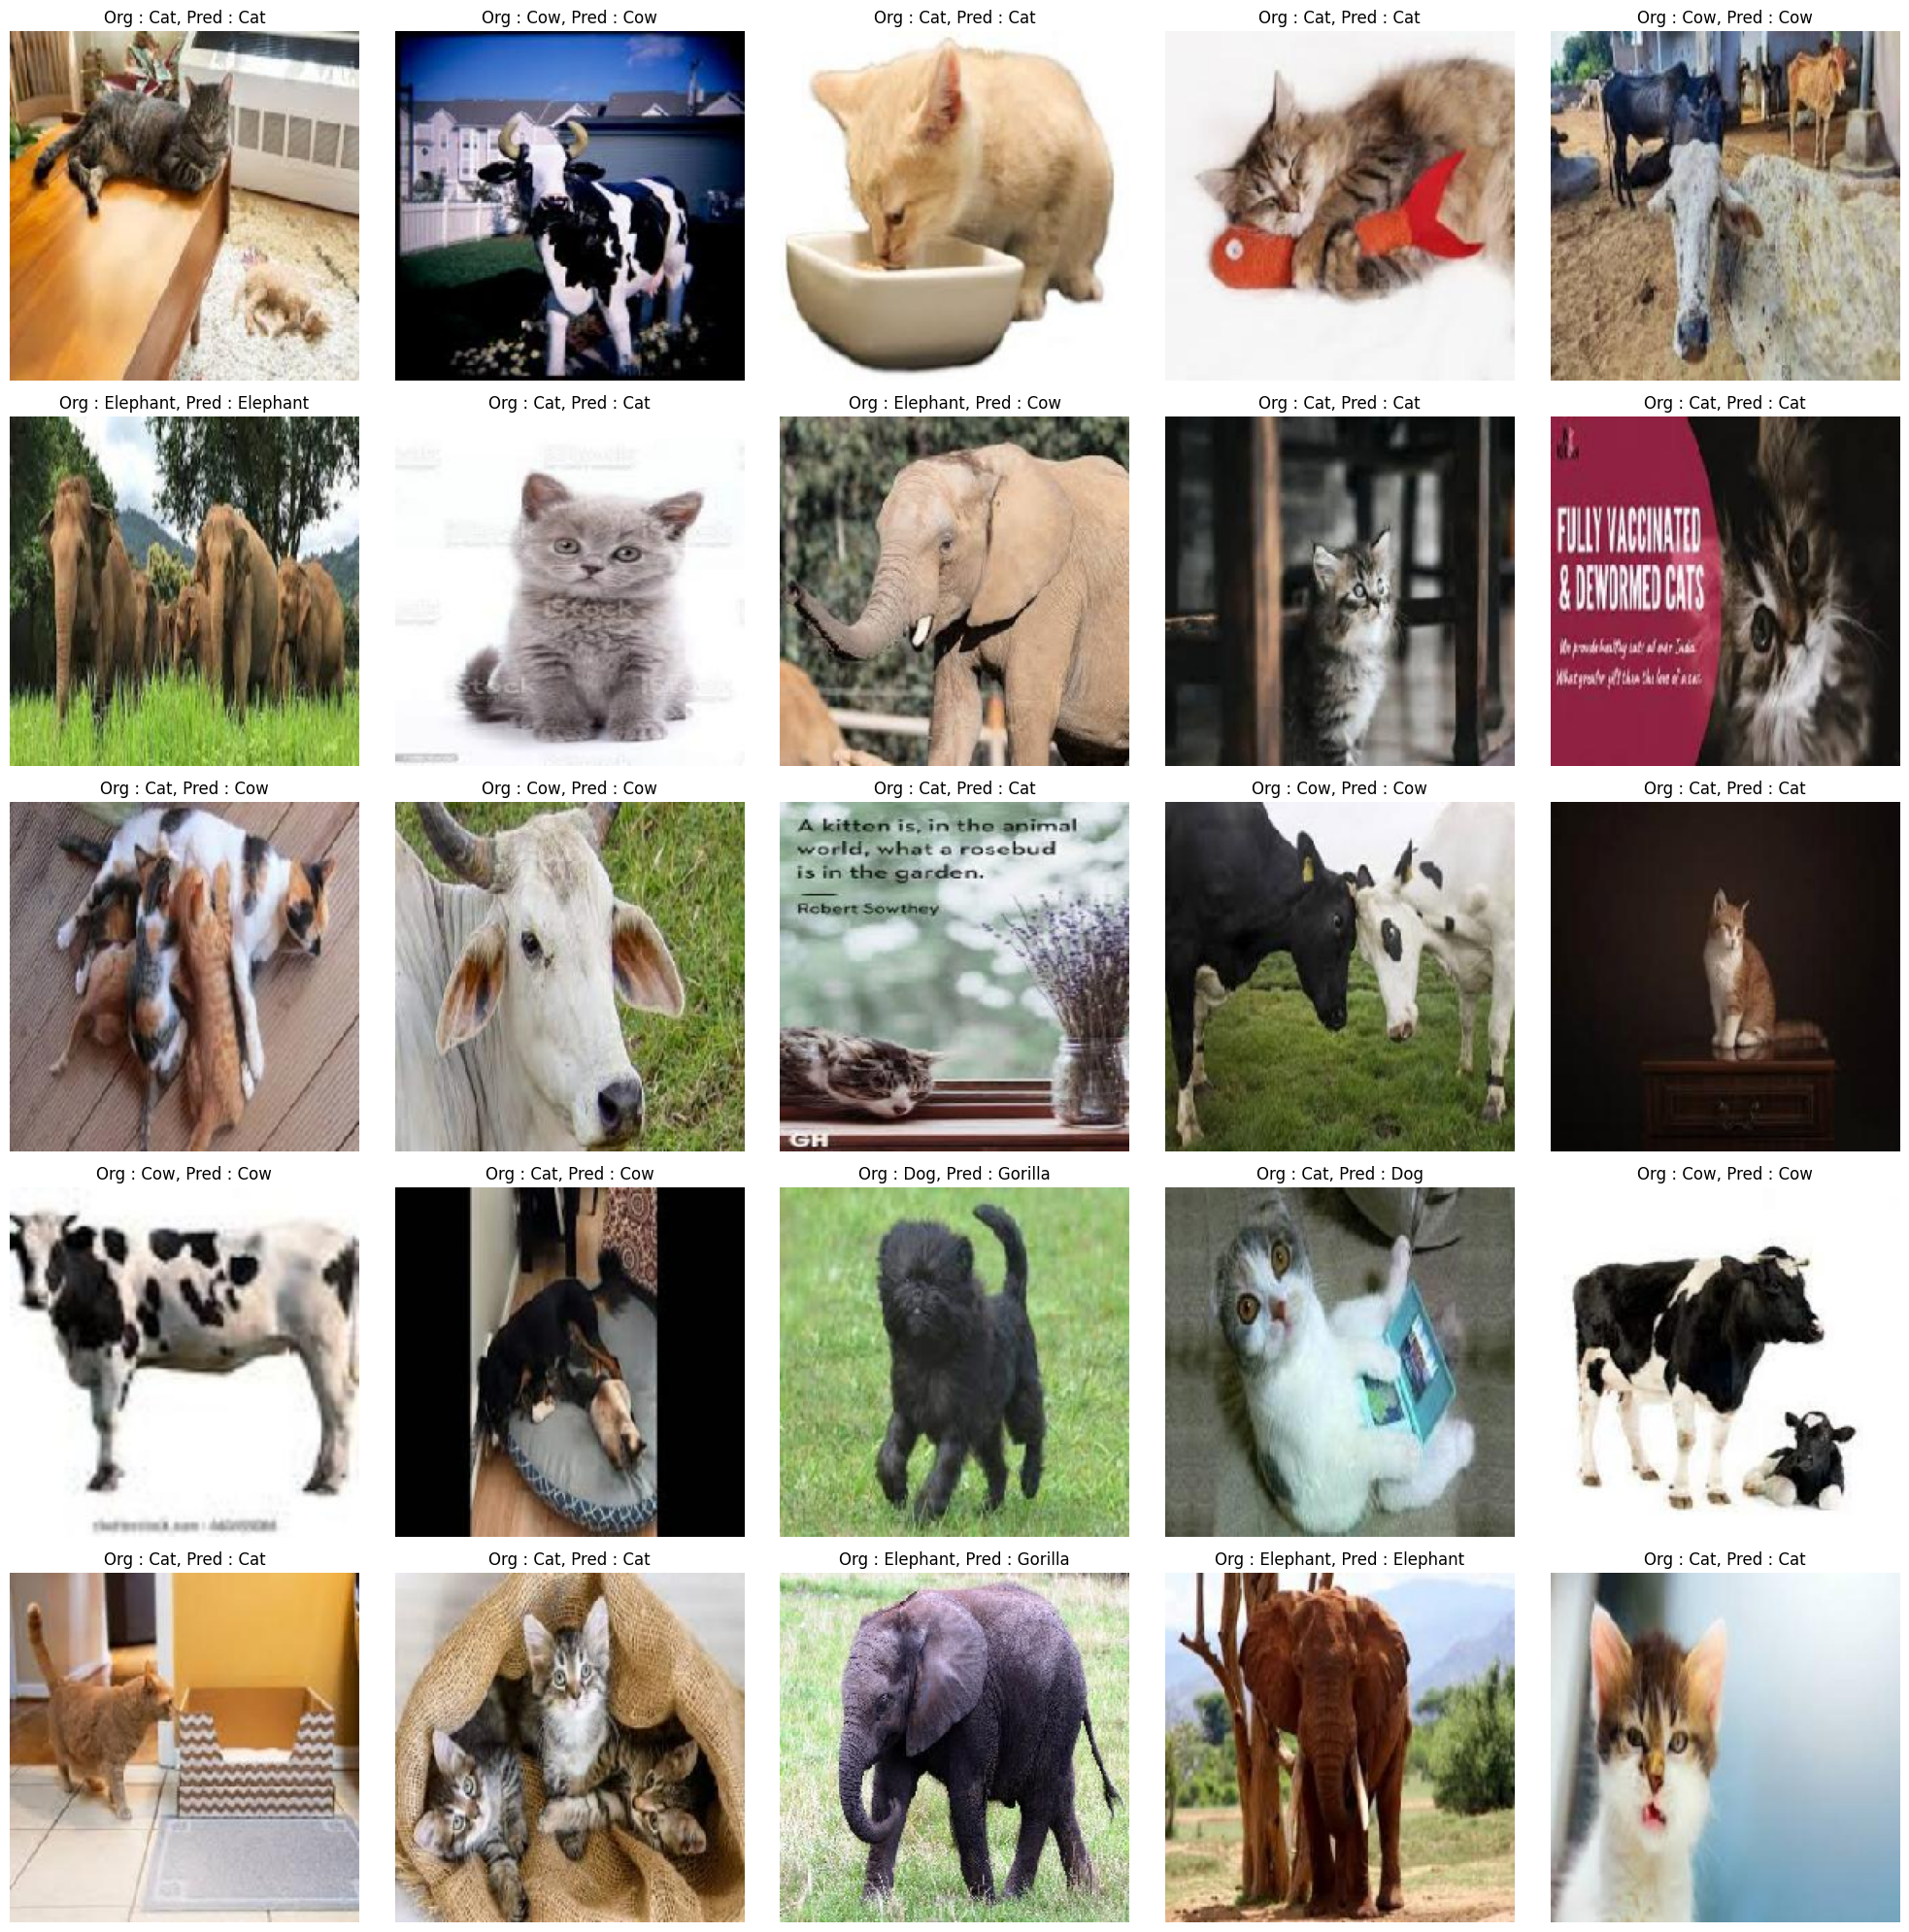

In [12]:
show_images(model=model, data=test_ds)

In [13]:
from sklearn.metrics import f1_score, classification_report

def calculate_f1_score_batch(model, images, labels):
    y_true = np.argmax(labels, axis=1)
    y_pred = np.argmax(model.predict(images), axis=1)

    f1_scores = f1_score(y_true, y_pred, average=None)
    avg_f1_score = f1_score(y_true, y_pred, average='weighted')  
    return f1_scores, avg_f1_score


1/1 [==============================] - 0s 47ms/step
F1 Scores for Model 1 (one batch): [0.8        0.76190476 0.28571429 0.83333333 0.85714286]
Average F1 Score for Model 1 (one batch): 0.7116071428571429


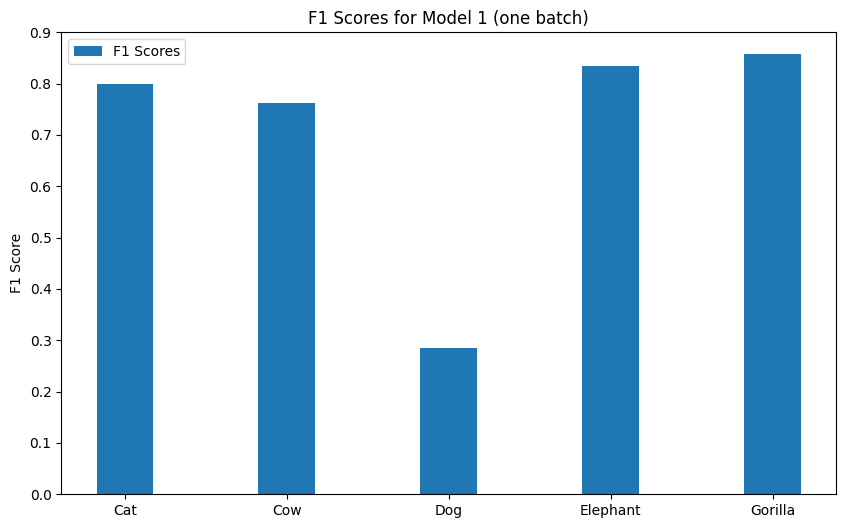

In [14]:
images_batch, labels_batch = next(iter(valid_ds))

f1_scores_batch, avg_f1_batch = calculate_f1_score_batch(model, images_batch, labels_batch)

print("F1 Scores for Model 1 (one batch):", f1_scores_batch)
print("Average F1 Score for Model 1 (one batch):", avg_f1_batch)

def plot_f1_scores_bar(f1_scores, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    ind = np.arange(len(class_names))

    rects1 = ax.bar(ind, f1_scores, width, label='F1 Scores')

    ax.set_xticks(ind)
    ax.set_xticklabels(class_names)
    ax.legend()

    ax.set_ylabel('F1 Score')
    ax.set_title(title)

    plt.show()

plot_f1_scores_bar(f1_scores_batch, class_names, 'F1 Scores for Model 1 (one batch)')


In [15]:
model.save("ResNet_5.h5")
model.save("ResNet_5.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

